In [4]:
import pandas as pd
import matplotlib.pyplot as plt

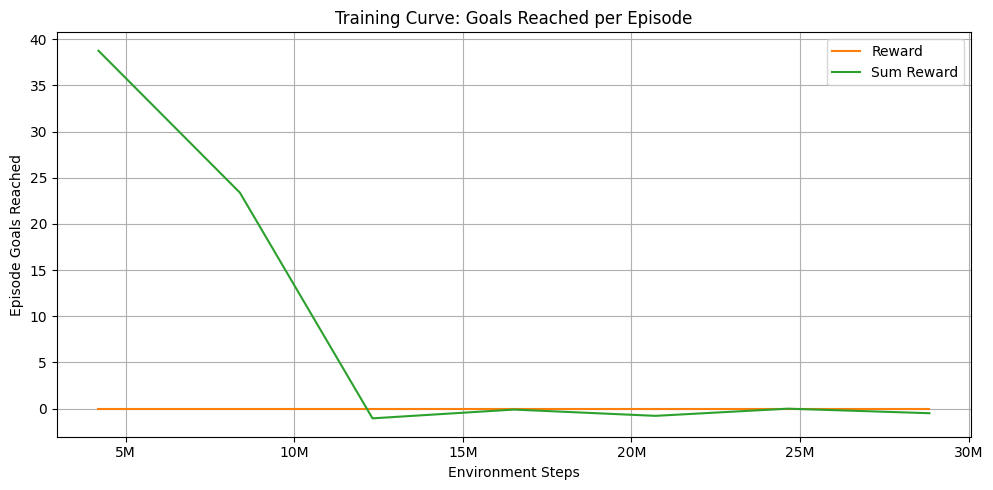

In [ ]:
# Fetch CSVs and preprocess for plotting

import logging

# Set up basic logging for error tracking
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

def load_and_clean_metrics_csv(path):
    """
    Loads the training metrics CSV, removes invalid rows, keeps the highest
    episode_goals_reached_count for each env_steps value, and filters the
    sequence so that each goals reached count is strictly larger than its predecessor.

    Args:
        path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Cleaned DataFrame ready for plotting.
    """
    try:
        df = pd.read_csv(path)
    except Exception as e:
        logging.error(f"Failed to read CSV at {path}: {e}")
        raise

    # Remove rows with NaNs in relevant columns
    df = df.dropna(subset=['env_steps', 'episode_reward', 'episode_sum_reward'])

    # Remove rows where episode_goals_reached_count <= 1
    df = df[df['episode_goals_reached_count'] > 1]

    # For duplicate env_steps, keep the row with the highest episode_goals_reached_count
    df = df.sort_values(['env_steps', 'episode_goals_reached_count'], ascending=[True, False])
    df = df.drop_duplicates(subset=['env_steps'], keep='first')

    # Sort by env_steps for plotting
    df = df.sort_values('env_steps').reset_index(drop=True)

    # Filter: keep only rows where episode_goals_reached_count is strictly larger than its predecessor
    def strictly_increasing_filter(goals_series):
        """
        Returns a boolean mask where True means the value is strictly greater than its predecessor.
        Always keeps the first value.
        """
        mask = [True]  # Always keep the first value
        last_val = goals_series.iloc[0]
        for val in goals_series.iloc[1:]:
            if val > last_val:
                mask.append(True)
                last_val = val
            else:
                mask.append(False)
        return mask

    # Apply the strictly increasing filter
    mask = strictly_increasing_filter(df['episode_goals_reached_count'])
    df = df[mask].reset_index(drop=True)

    return df

def plot_goals_reached_over_steps(df, window=50):
    """
    Plots the number of goals reached per episode over environment steps.
    Applies a rolling mean for smoothing.

    Args:
        df (pd.DataFrame): DataFrame containing training metrics.
        window (int): Window size for rolling mean smoothing.
    """
    required_cols = ['env_steps', 'episode_goals_reached_count']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame.")

    # Apply rolling mean for smoothing
    goals = df['episode_goals_reached_count'].rolling(window=window, min_periods=1).mean()
    
    reward = df['episode_reward'].rolling(window=window, min_periods=1).mean()
    sum_reward = df['episode_sum_reward']
    
    import matplotlib.ticker as mticker

    plt.figure(figsize=(10, 5))
    plt.plot(df['env_steps'], reward, label='Reward', color='tab:orange')
    plt.plot(df['env_steps'], sum_reward, label='Sum Reward', color='tab:green')
    plt.xlabel('Environment Steps')
    plt.ylabel('Episode Goals Reached')
    plt.title('Training Curve: Goals Reached per Episode')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Format x-axis ticks to show millions with 'M' (no decimal) instead of scientific notation
    ax = plt.gca()
    def millions_formatter(x, pos):
        if x >= 1e6:
            return f'{int(x // 1_000_000)}M'
        else:
            return f'{int(x)}'
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))

    plt.show()

# Path to the metrics CSV file
path = '../runs/experimental_results/point-resetting-goal-random-hazard-lidar-sensor-obs/ppo_lagrange/point_resetting_goal_random_hazard_lidar_sensor_obs_ppo_lagrange_bound0.2_lr0.001_goal0.7_seed0_20250829_221753_train_metrics.csv'

# Load and clean the data
df = load_and_clean_metrics_csv(path)

# Call the plotting function
plot_goals_reached_over_steps(df)


In [6]:
# Display a DataFrame with environment steps and goals reached for inspection
df = pd.read_csv(path)
df_steps_goals = df[['env_steps', 'episode_sum_reward']]
print(df_steps_goals)

     env_steps  episode_sum_reward
0      4194304            38.76329
1      4456448            38.76329
2      4718592            38.76329
3      4980736            38.76329
4      5242880            38.76329
..         ...                 ...
101   29884416            -0.49974
102   30146560            -0.49974
103   30408704            -0.49974
104   30408704                 NaN
105   30000000                 NaN

[106 rows x 2 columns]
